In [1]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import gzip
from anndata import AnnData
import requests
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

In [2]:
def download_binary_file(file_url: str, output_path: str) -> None:
    """
    Download binary data file from a URL.

    Args:
    ----
        file_url: URL where the file is hosted.
        output_path: Output path for the downloaded file.

    Returns
    -------
        None.
    """
    request = requests.get(file_url)
    with open(output_path, "wb") as f:
        f.write(request.content)
    print(f"Downloaded data from {file_url} at {output_path}")

    

def download_haber_2017(output_path: str) -> None:
    """
    Download Haber et al. 2017 data from the hosting URLs.

    Args:
    ----
        output_path: Output path to store the downloaded and unzipped
        directories.

    Returns
    -------
        None. File directories are downloaded to output_path.
    """

    url = (
        "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92332/suppl/GSE92332"
        "_SalmHelm_UMIcounts.txt.gz"
    )

    output_filename = os.path.join(output_path, url.split("/")[-1])

    download_binary_file(url, output_filename)
def read_haber_2017(file_directory: str) -> pd.DataFrame:
    """
    Read the expression data from Haber et al. 2017 given the directory.

    Args:
    ----
        file_directory: Directory containing Haber et al. 2017 data.

    Returns
    -------
        A DataFrame containing single-cell gene expression counts, with cell
        identification barcodes as column names and gene IDs as indices.
    """

    # Path to the file
    file_path = os.path.join(file_directory, "GSE92332_SalmHelm_UMIcounts.txt.gz")
    
    # Read the .txt.gz file, assuming the first column contains gene names
    with gzip.open(file_path, "rt") as f:
        df = pd.read_csv(f, sep="\t", index_col=0)

    return df

def preprocess_haber_2017(download_path: str, n_top_genes: int) -> (AnnData, list):
    """
    Preprocess expression data from Haber et al. 2017.

    Args:
    ----
        download_path: Path containing the downloaded Haber et al. 2017 data file.
        n_top_genes: Number of most variable genes to retain.

    Returns
    -------
        An AnnData object containing single-cell expression data. The layer
        "count" contains the count data for the most variable genes. The X
        variable contains the total-count-normalized and log-transformed data
        for the most variable genes (a copy with all the genes is stored in
        .raw).
        A list of conditions associated with each cell.
    """

    # Read the expression data
    df = read_haber_2017(download_path)
    
    # Transpose the dataframe so that genes become columns and cells are rows
    df = df.transpose()

    # Extract metadata from the cell names
    cell_groups = []
    barcodes = []
    conditions = []
    cell_types = []
    cell_names = []

    for cell in df.index:
        try:
            cell_group, barcode, condition, cell_type = cell.split("_")
            cell_groups.append(cell_group)
            barcodes.append(barcode)
            conditions.append(condition)
            cell_types.append(cell_type)
            cell_names.append(cell)
        except ValueError:
            print(f"Error parsing cell name: {cell}")
            continue

    # Create a DataFrame for metadata
    metadata_df = pd.DataFrame(
        {
            "cell_group": cell_groups,
            "barcode": barcodes,
            "condition": conditions,
            "cell_type": cell_types,
        }, index=cell_names  # Ensure the cell names are set as the index
    )

    # Create the AnnData object with gene names in 'var' and cell metadata in 'obs'
    adata = AnnData(X=df.values, obs=metadata_df, var=pd.DataFrame(index=df.columns))

    # Preprocess the data: normalize, log-transform, and keep most variable genes
    adata = adata[adata.obs["condition"] != "Hpoly.Day3"]
    adata.layers["count"] = adata.X.copy()

    # Normalize and log-transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.raw = adata

    # Select highly variable genes
    sc.pp.highly_variable_genes(
        adata, flavor="seurat_v3", n_top_genes=n_top_genes, layer="count", subset=True
    )

    # Remove cells with all zero counts
    adata = adata[adata.layers["count"].sum(1) != 0]  # Remove cells with all zeros.

    # Return the AnnData object and the conditions list
    return adata, conditions


In [3]:
root_data_path = '/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen'
   # local computer data path to downloaad the dataset. 

#download_haber_2017(root_data_path)

In [4]:
data, conditions = preprocess_haber_2017(root_data_path, 1000)

/var/folders/8z/wrr8y5fn609_d770khfs09mw0000gn/T/ipykernel_7670/2981370562.py:125: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata.layers["count"] = adata.X.copy()


In [5]:
foreground = data[data.obs["condition"] != "Control"]
k, p = foreground.shape

background = data[data.obs["condition"] == "Control"]
m, p = background.shape

foreground = foreground.to_df()
background = background.to_df()

labels = np.where(foreground.index.str.contains('Salmonella'), 0, 1)

In [6]:
genes = foreground.columns.to_numpy()
foreground_cells = foreground.index.to_numpy()
X = foreground.to_numpy()
Y = background.to_numpy()

In [7]:
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/')
from main import*

In [10]:
cols_contrastive, rows_contrastive, hist = iccur(
       X, Y, cols=10, rows=50, k=7,
       max_iter=100, epsilon=1e-6,
       theta_S=0.90, theta_T=0.90, patience=2,
       verbose=True
 )

genes[cols_contrastive]

array(['B3galt5', 'Gm6696', 'Hspa1a', 'Lrg1', 'Mptx2', 'Pla2g4c',
       'Retnlb', 'Saa1', 'Sptssb', 'Wfdc18'], dtype=object)

## non-iterative version ##

In [11]:
c = 10
k = 7
cols_contrastive = ccur(X, Y, k, c)[0]
genes[cols_contrastive]

array(['Retnlb', 'Lrg1', 'Saa1', 'B3galt5', 'Pla2g4c', 'Prss53', 'Mptx2',
       'Hspa1a', 'Tat', 'Gm6696'], dtype=object)

In [12]:
cols_foreground = deterministic_cur(X, k, c)[3]
genes[cols_foreground]

array(['Reg3g', 'Defa24', 'Fabp6', 'Tff3', 'Fabp1', 'Lypd8', 'Spink4',
       'Krt19', 'Guca2a', 'Apoa1'], dtype=object)

In [13]:
union_indicies = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
genes[union_indicies]

array(['Reg3g', 'Fabp6', 'Krt19', 'Defa24', 'Tff3', 'Fabp1', 'Lypd8',
       'Guca2a', 'Spink4', 'Apoa1'], dtype=object)

In [14]:
alpha = 1
constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
cpca_indices = np.argsort(np.abs(first_pc))[-c:] 
genes[cpca_indices]

array(['Clec2h', 'Anpep', 'Guca2b', 'Defa24', 'Fabp2', 'Reg3g', 'Apoa4',
       'Fabp1', 'Rbp2', 'Apoa1'], dtype=object)

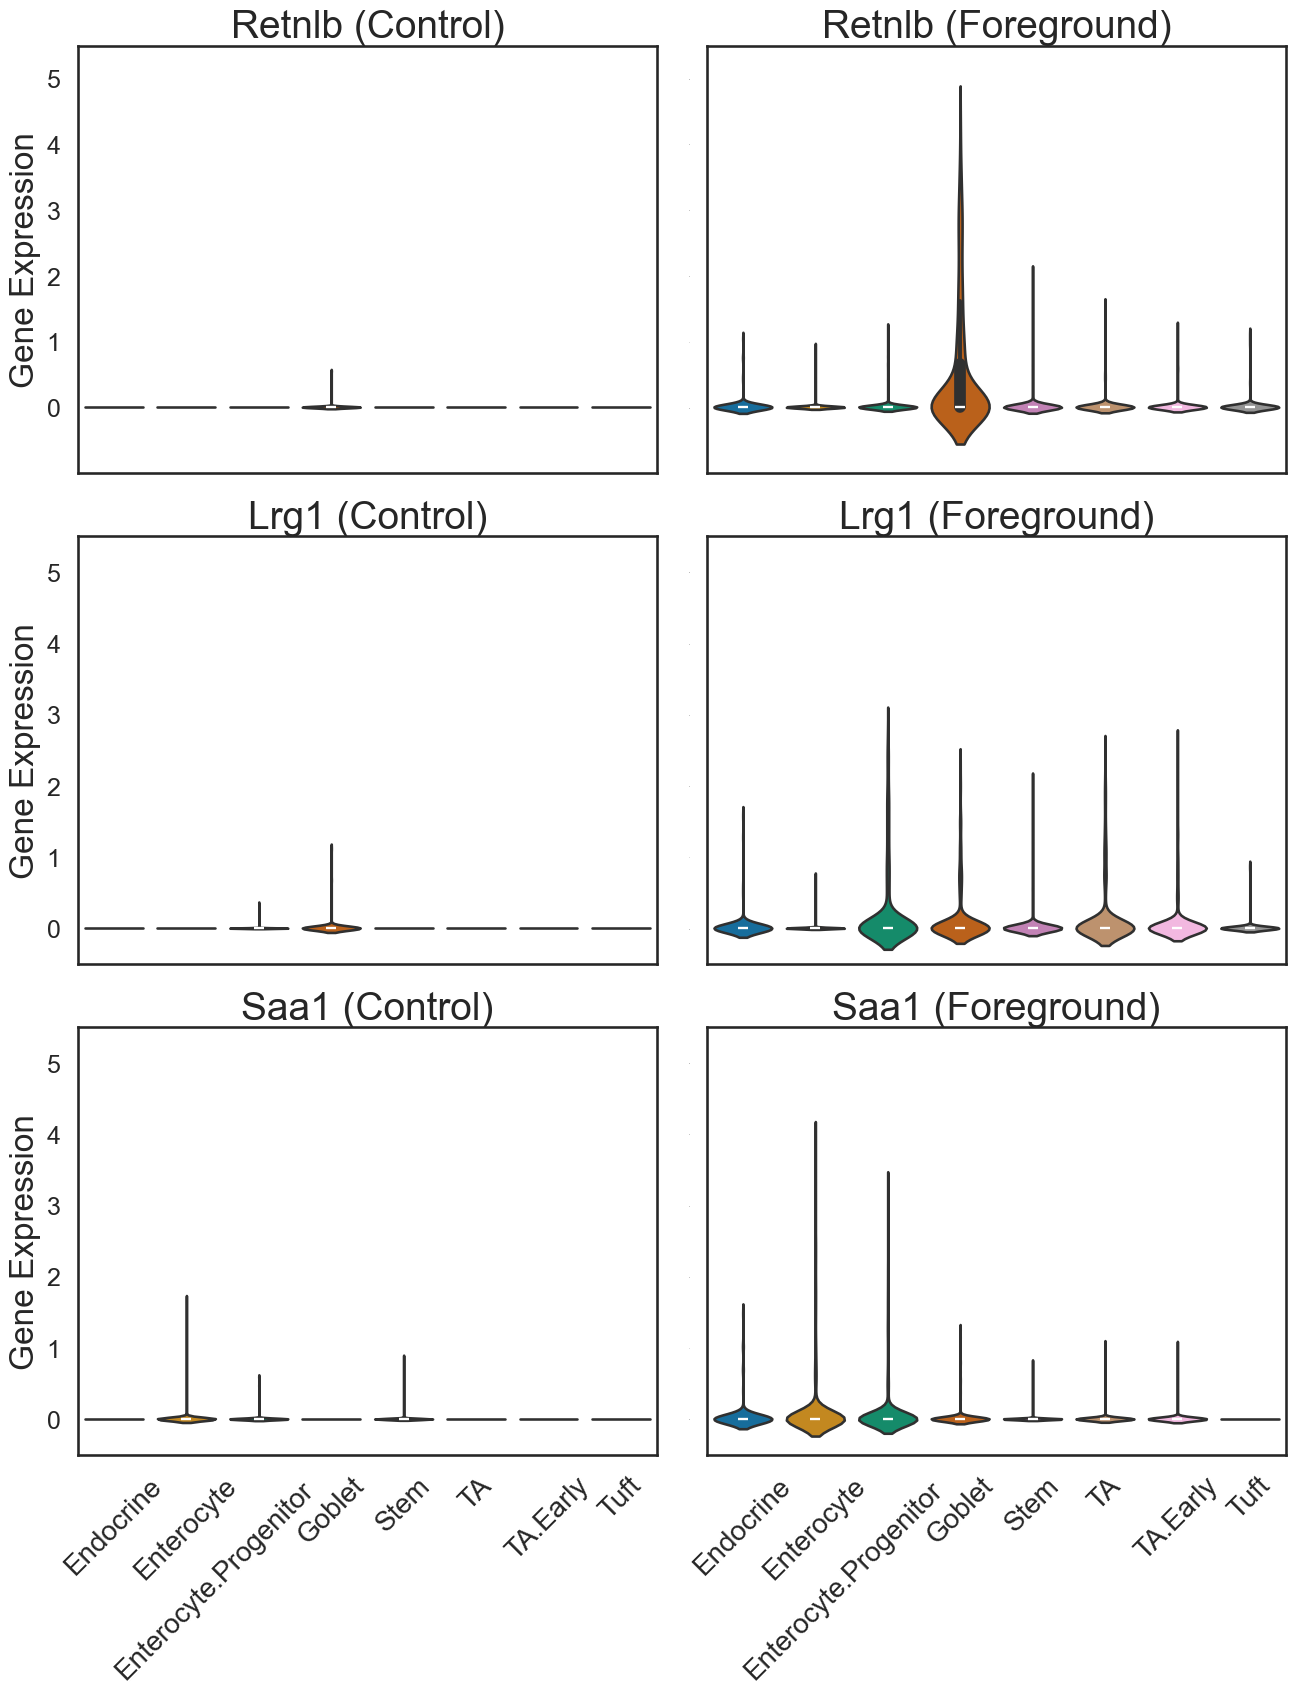

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

indices_to_plot = [0, 1, 2]
gene_names = [foreground.columns[cols_contrastive[i]] for i in indices_to_plot]

foreground_cell_types = pd.Series(foreground.index.map(lambda x: x.split('_')[-1]), index=foreground.index)
background_cell_types = pd.Series(background.index.map(lambda x: x.split('_')[-1]), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

palette = sns.color_palette("colorblind", len(all_cell_types))
palette_dict = dict(zip(all_cell_types, palette))  

sns.set_theme(style="white", context="talk", palette="colorblind")
plt.close('all')  

fig, axes = plt.subplots(
    nrows=len(indices_to_plot),
    ncols=2,
    figsize=(14, 6 * len(indices_to_plot)),
    sharex='col'
)

axes = np.atleast_2d(axes)

y_min_global = -0.5  
y_max_global = max(
    foreground.iloc[:, cols_contrastive].max().max(),
    background.iloc[:, cols_contrastive].max().max()
) + 0.5  

for i, (gene_index, gene_name) in enumerate(zip(indices_to_plot, gene_names)):
    foreground_gene_data = foreground.iloc[:, cols_contrastive[gene_index]]
    background_gene_data = background.iloc[:, cols_contrastive[gene_index]]

    data_foreground = pd.DataFrame({
        'Gene Expression': foreground_gene_data,
        'Cell Type': foreground_cell_types
    })

    data_background = pd.DataFrame({
        'Gene Expression': background_gene_data,
        'Cell Type': background_cell_types
    })

    if i == 0:
        y_min_adjusted = y_min_global - 0.5  
    else:
        y_min_adjusted = y_min_global

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background,
        order=all_cell_types, ax=axes[i, 0], palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=28)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=24)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 0].tick_params(axis='y', labelsize=18)
    axes[i, 0].set_ylim(y_min_adjusted, y_max_global)  

    tick_labels_control = axes[i, 0].get_xticklabels()
    if len(tick_labels_control) > 2:  
        third_label_control = tick_labels_control[2]
        axes[i, 0].text(
            1.4, y_min_adjusted - 0.3, third_label_control.get_text(),  
            fontsize=20, ha='center', va='top', rotation=45
        )
        third_label_control.set_visible(False)  

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_foreground,
        order=all_cell_types, ax=axes[i, 1], palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Foreground)", fontsize=28)
    axes[i, 1].set_ylabel("")  
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 1].tick_params(axis='y', labelsize=0)
    axes[i, 1].set_ylim(y_min_adjusted, y_max_global) 

    tick_labels_foreground = axes[i, 1].get_xticklabels()
    if len(tick_labels_foreground) > 2:  
        third_label_foreground = tick_labels_foreground[2]
        axes[i, 1].text(
            1.4, y_min_adjusted - 0.3, third_label_foreground.get_text(),  
            fontsize=20, ha='center', va='top', rotation=45
        )
        third_label_foreground.set_visible(False) 


    for ax in [axes[i, 0], axes[i, 1]]:
        ax.set_yticks([0, 1, 2, 3, 4, 5])  
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) 

for ax in axes[-1, :]:
    ax.set_xlabel("", fontsize=24)

plt.tight_layout(rect=[0.05, 0, 1, 0.96])  

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_combined.png', dpi=300, bbox_inches='tight')
plt.show()


In [35]:
r =50
k=7
rows_contrastive = deterministic_cur(X[:,cols_contrastive],k,r)[4]
rows_foreground = deterministic_cur(X,k, r)[4]


In [19]:
r =50
k=7
rows_foreground = deterministic_cur(X,k, r)[4]


In [ ]:
adata = sc.AnnData(foreground.values)
adata.obs['barcode'] = foreground.index
adata.var['gene_name'] = foreground.columns

adata.obs['cell_type'] = adata.obs['barcode'].apply(lambda x: x.split('_')[-1])

sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

contrastive_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[rows_contrastive])].tolist()
foreground_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[rows_foreground])].tolist()
contrastive_indices = [int(i) for i in contrastive_indices]
foreground_indices = [int(i) for i in foreground_indices]

coords = adata.obsm['X_umap']

unique_cell_types = sorted(adata.obs['cell_type'].unique())

palette = dict(zip(unique_cell_types, sns.color_palette("colorblind", len(unique_cell_types))))

plt.figure(figsize=(8, 6))

for cell_type in unique_cell_types:
    cell_type_indices = adata.obs.index[adata.obs['cell_type'] == cell_type]
    cell_type_coords = coords[[int(idx) for idx in cell_type_indices], :]
    plt.scatter(
        cell_type_coords[:, 0],
        cell_type_coords[:, 1],
        color=palette[cell_type],
        s=20,
        alpha=1,
        label=cell_type
    )

plt.scatter(
    coords[contrastive_indices, 0],
    coords[contrastive_indices, 1],
    color='black',
    marker='x',
    s=50,
    label='CCUR'
)

plt.scatter(
    coords[foreground_indices, 0],
    coords[foreground_indices, 1],
    color='black',
    edgecolor='black',  
    marker='^',
    s=30,
    label='CUR-Foreground'
)

plt.title("UMAP", fontsize=22)
plt.xlabel("UMAP 1", fontsize=22, labelpad=10)
plt.ylabel("UMAP 2", fontsize=22, labelpad=10)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

handles, labels = [], []
for cell_type in unique_cell_types:
    handles.append(plt.Line2D([0], [0], marker='o', color=palette[cell_type], markersize=12, linestyle='None'))
    labels.append(cell_type)

handles.append(plt.Line2D([0], [0], marker='x', color='black', markersize=14, markeredgewidth = 2,linestyle='None', label='CCUR'))
labels.append('CCUR')
handles.append(plt.Line2D([0], [0], marker='^', color='black', markersize=12, linestyle='None', label='CUR-Foreground'))
labels.append('CUR-Foreground')

plt.legend(
    handles=handles,
    labels=labels,
    title="",
    title_fontsize=14,
    fontsize=18,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False
)

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_rows.png', dpi=300, bbox_inches='tight')
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


In [1]:
adata.obs['int_index'] = adata.obs.index.astype(int)

index_to_cell_type = adata.obs.set_index('int_index')['cell_type']

results = {}

methods = {
    'CCUR': rows_contrastive,
    'CUR': rows_foreground,
}

for method_name, indices in methods.items():
    indices = [int(i) for i in indices]
    
    selected_cell_types = index_to_cell_type.loc[indices]
    counts = selected_cell_types.value_counts()
    
    proportions = counts / counts.sum()
    
    results[method_name] = proportions

total_cell_counts = adata.obs['cell_type'].value_counts()
total_proportions = total_cell_counts / total_cell_counts.sum()

results_df = pd.DataFrame(results).fillna(0)

results_df['True_Proportion'] = total_proportions


print(results_df)


NameError: name 'adata' is not defined

## Supplementary

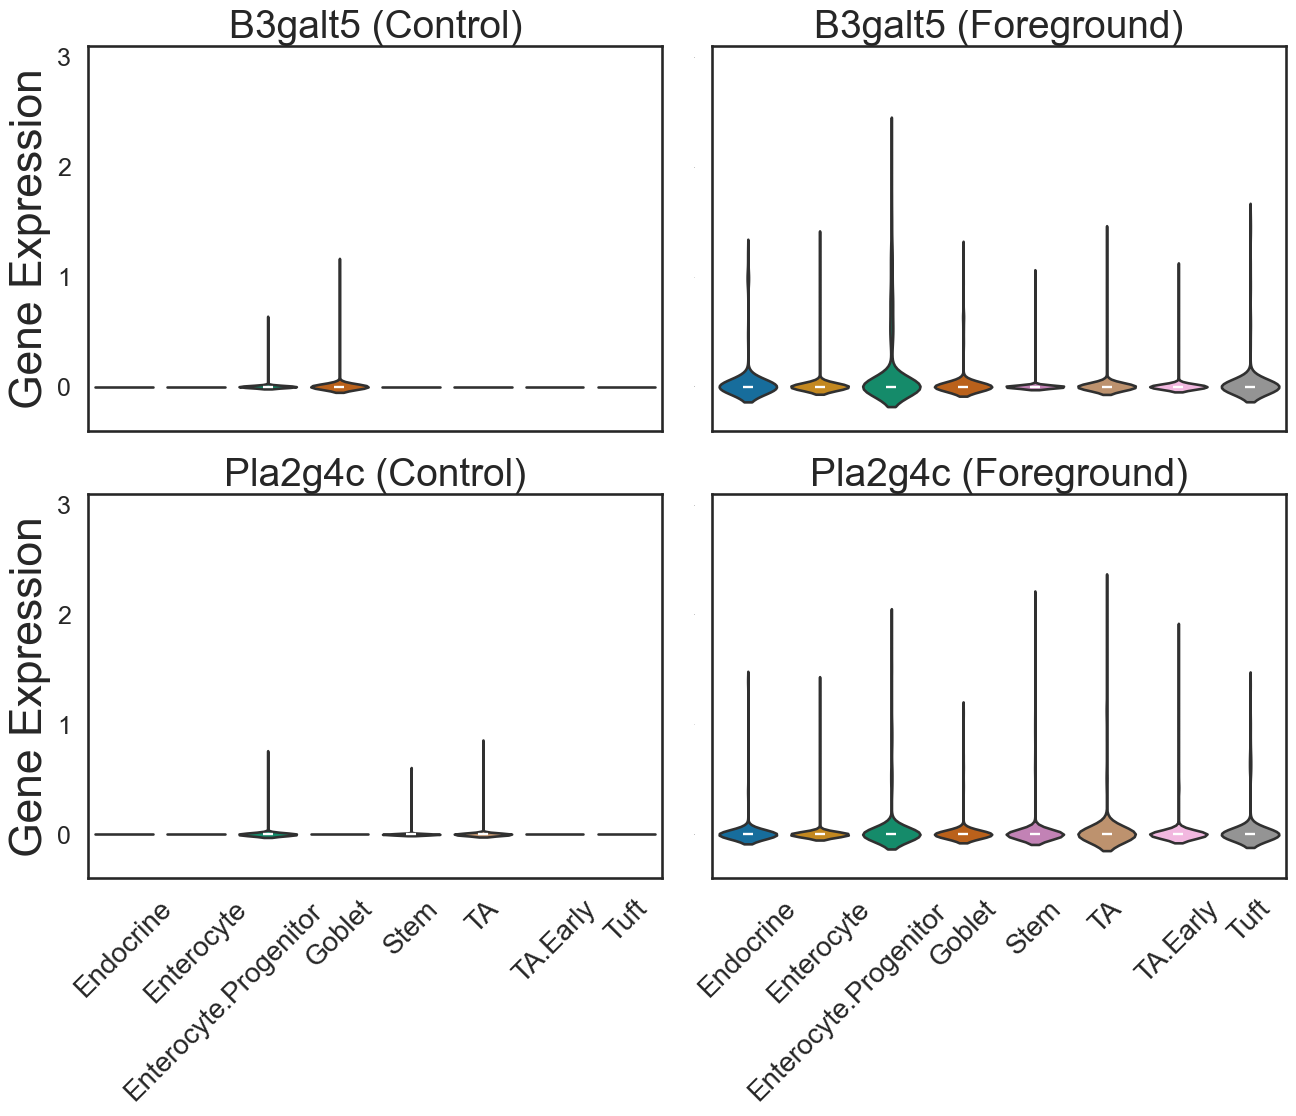

In [44]:
warnings.simplefilter(action='ignore', category=FutureWarning)

indices_to_plot = [3, 4]
gene_names = [foreground.columns[cols_contrastive[i]] for i in indices_to_plot]

foreground_cell_types = pd.Series(foreground.index.map(lambda x: x.split('_')[-1]), index=foreground.index)
background_cell_types = pd.Series(background.index.map(lambda x: x.split('_')[-1]), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

palette = sns.color_palette("colorblind", len(all_cell_types))
palette_dict = dict(zip(all_cell_types, palette))  

sns.set_theme(style="white", context="talk", palette="colorblind")
fig, axes = plt.subplots(len(indices_to_plot), 2, figsize=(14, 6 * len(indices_to_plot)), sharex='col')

y_min_global = -0.4  
y_max_global = 3.1  

for i, (gene_index, gene_name) in enumerate(zip(indices_to_plot, gene_names)):
    foreground_gene_data = foreground.iloc[:, cols_contrastive[gene_index]]
    background_gene_data = background.iloc[:, cols_contrastive[gene_index]]

    data_foreground = pd.DataFrame({
        'Gene Expression': foreground_gene_data,
        'Cell Type': foreground_cell_types
    })

    data_background = pd.DataFrame({
        'Gene Expression': background_gene_data,
        'Cell Type': background_cell_types
    })

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background,
        order=all_cell_types, ax=axes[i, 0], palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=28)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=32)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 0].tick_params(axis='y', labelsize=18)
    axes[i, 0].set_ylim(y_min_global, y_max_global)  

    tick_labels_control = axes[i, 0].get_xticklabels()
    if len(tick_labels_control) > 2:  
        third_label_control = tick_labels_control[2]
        axes[i, 0].text(
            1.4, y_min_global - 0.18, third_label_control.get_text(),  
            fontsize=20, ha='center', va='top', rotation=45
        )
        third_label_control.set_visible(False)  

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_foreground,
        order=all_cell_types, ax=axes[i, 1], palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Foreground)", fontsize=28)
    axes[i, 1].set_ylabel("")  
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 1].tick_params(axis='y', labelsize=0)
    axes[i, 1].set_ylim(y_min_global, y_max_global)  

    tick_labels_foreground = axes[i, 1].get_xticklabels()
    if len(tick_labels_foreground) > 2:  
        third_label_foreground = tick_labels_foreground[2]
        axes[i, 1].text(
            1.4, y_min_global - 0.18, third_label_foreground.get_text(),  
            fontsize=20, ha='center', va='top', rotation=45
        )
        third_label_foreground.set_visible(False) 

for ax in axes[-1, :]:
    ax.set_xlabel("", fontsize=24)

for ax in axes.flatten():
    ax.set_yticks([0, 1, 2, 3])  
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

plt.tight_layout(rect=[0.05, 0, 1, 0.96])  

os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_ccur_suppl.png', dpi=300, bbox_inches='tight')
plt.show()



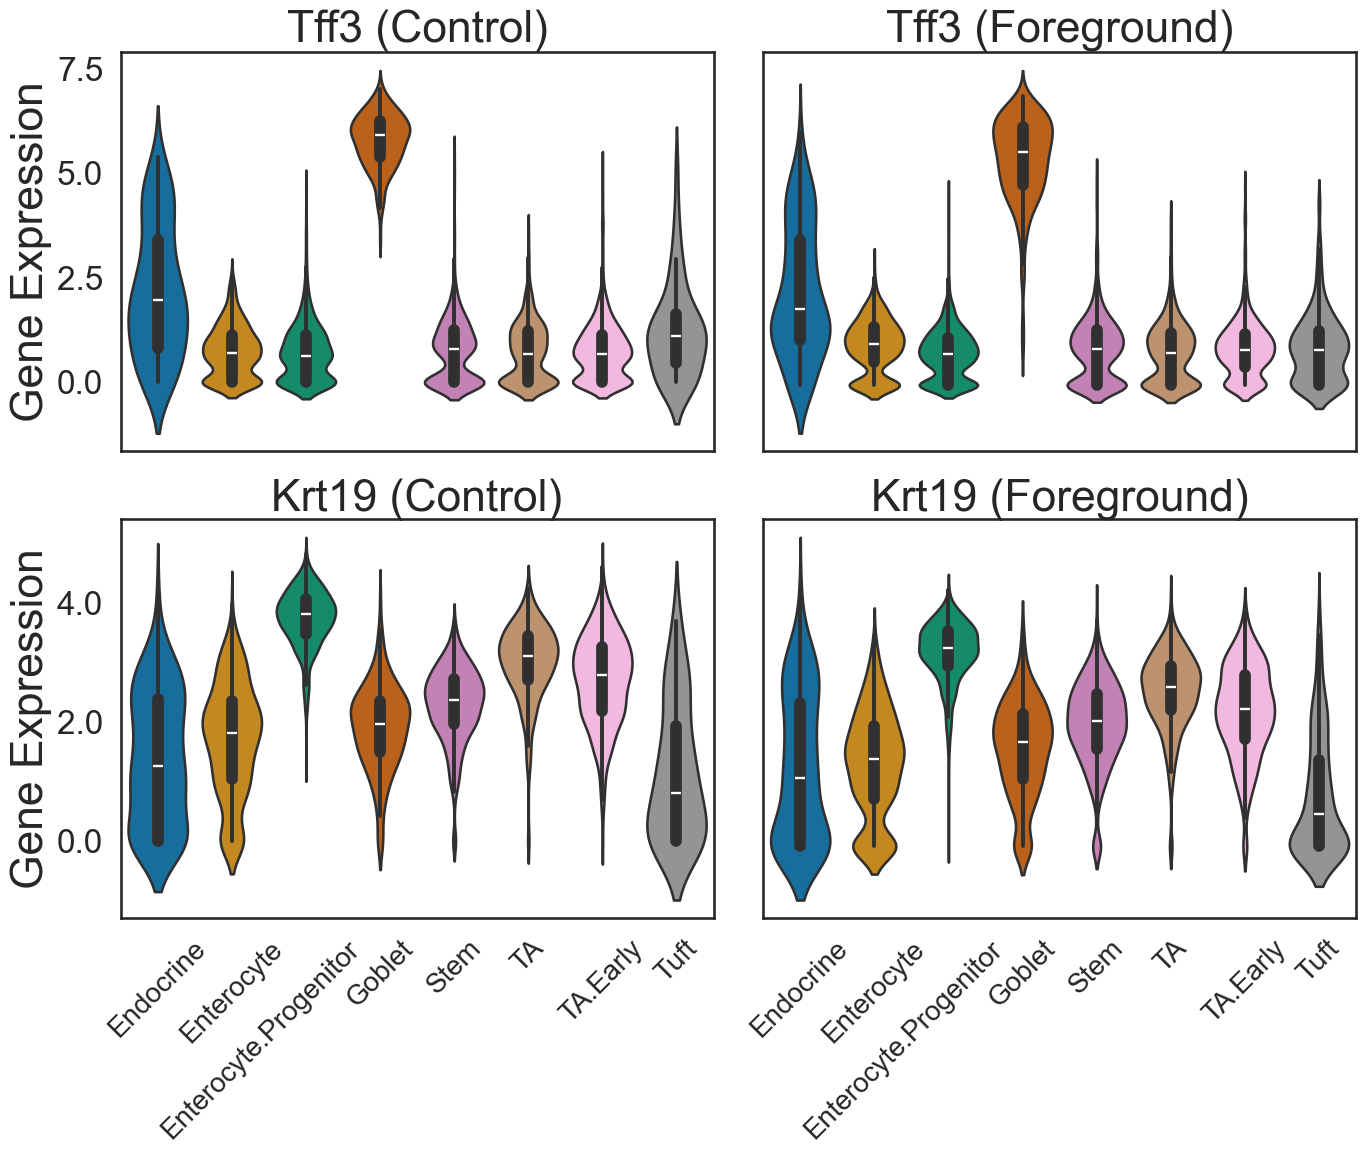

In [46]:
warnings.simplefilter(action='ignore', category=FutureWarning)

indices_to_plot = [3, 7]
gene_names = [foreground.columns[cols_foreground[i]] for i in indices_to_plot]

foreground_cell_types = pd.Series(foreground.index.map(lambda x: x.split('_')[-1]), index=foreground.index)
background_cell_types = pd.Series(background.index.map(lambda x: x.split('_')[-1]), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

palette = sns.color_palette("colorblind", len(all_cell_types))
palette_dict = dict(zip(all_cell_types, palette))  

sns.set_theme(style="white", context="talk", palette="colorblind")
fig, axes = plt.subplots(len(indices_to_plot), 2, figsize=(14, 6 * len(indices_to_plot)), sharex='col')

for i, (gene_index, gene_name) in enumerate(zip(indices_to_plot, gene_names)):
    foreground_gene_data = foreground.iloc[:, cols_foreground[gene_index]]
    background_gene_data = background.iloc[:, cols_foreground[gene_index]]

    data_foreground = pd.DataFrame({
        'Gene Expression': foreground_gene_data,
        'Cell Type': foreground_cell_types
    })

    data_background = pd.DataFrame({
        'Gene Expression': background_gene_data,
        'Cell Type': background_cell_types
    })

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background,
        order=all_cell_types, ax=axes[i, 0], palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=32)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=32)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 0].tick_params(axis='y', labelsize=24)
    axes[i, 0].yaxis.set_major_locator(MaxNLocator(integer=True))

    if i == 0 or i == 1 or i == 2:
        axes[i, 0].yaxis.set_major_locator(MaxNLocator(nbins=4))  
    axes[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 

    tick_labels_control = axes[i, 0].get_xticklabels()
    if len(tick_labels_control) > 2:  
        third_label_control = tick_labels_control[2]
        axes[i, 0].text(
            1.4, -5.1, third_label_control.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_control.set_visible(False)

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_foreground,
        order=all_cell_types, ax=axes[i, 1], palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Foreground)", fontsize=32)
    axes[i, 1].set_ylabel("")  
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 1].tick_params(axis='y', left=False, labelleft=False)  

    tick_labels_foreground = axes[i, 1].get_xticklabels()
    if len(tick_labels_foreground) > 2: 
        third_label_foreground = tick_labels_foreground[2]
        axes[i, 1].text(
            1.4, -5, third_label_foreground.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_foreground.set_visible(False)

for ax in axes[-1, :]:
    ax.set_xlabel("", fontsize=16)

plt.tight_layout()  
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_cur_suppl.png', dpi=300, bbox_inches='tight')
plt.show()


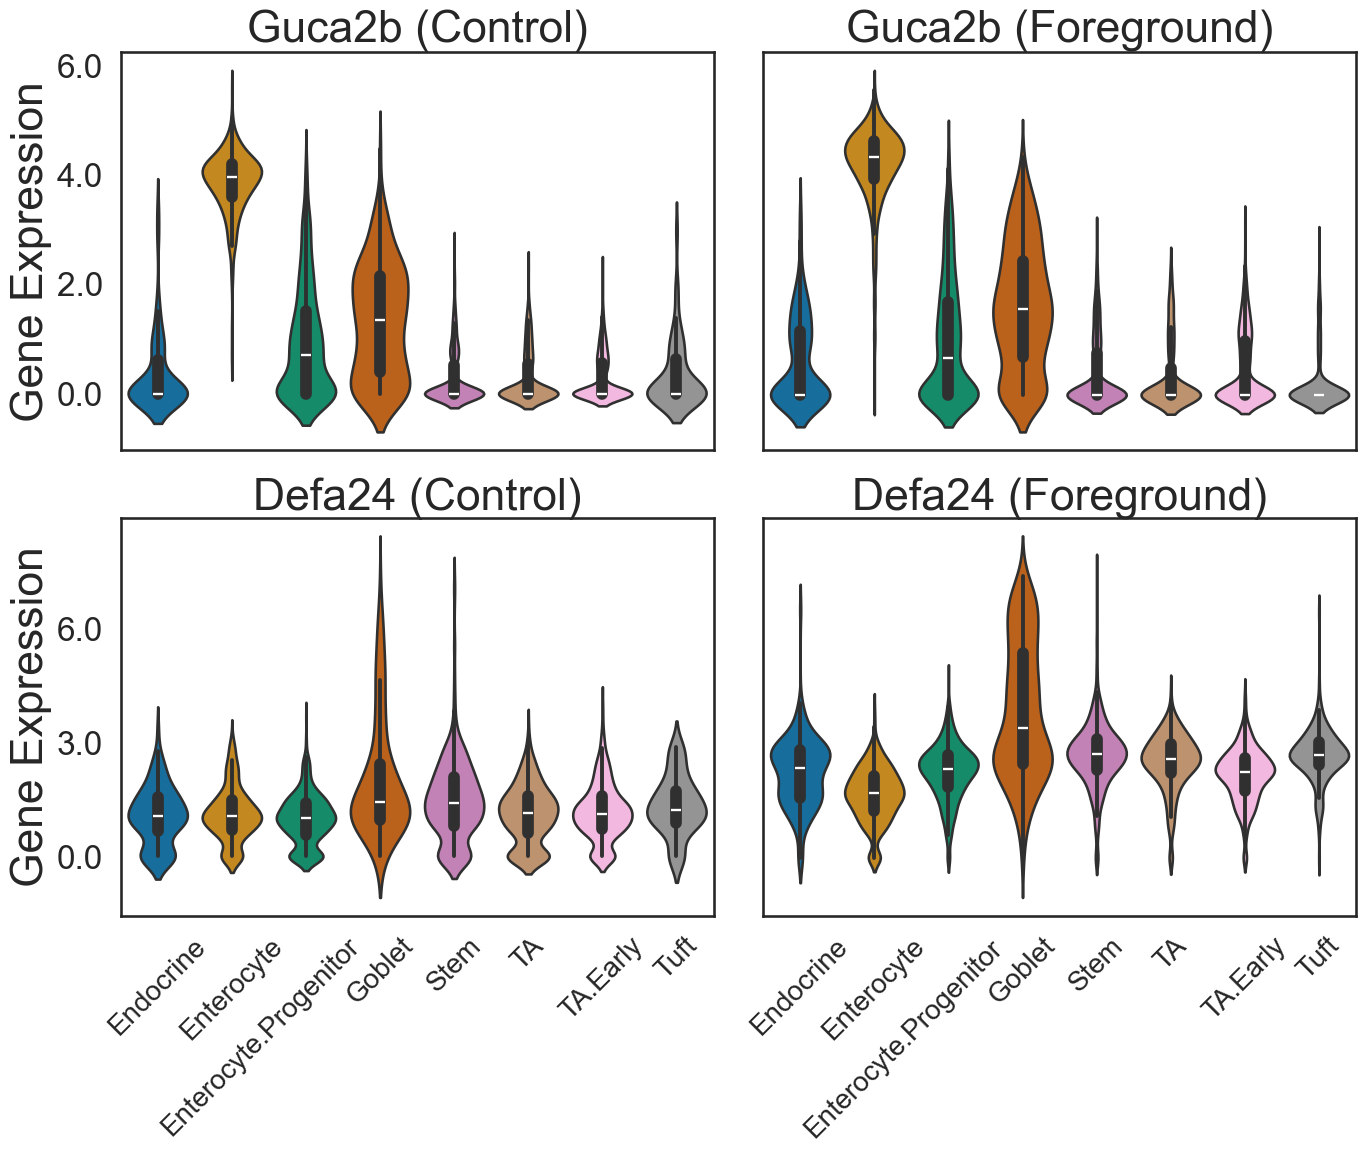

In [48]:
warnings.simplefilter(action='ignore', category=FutureWarning)

indices_to_plot = [2, 3]
gene_names = [foreground.columns[cpca_indices[i]] for i in indices_to_plot]

foreground_cell_types = pd.Series(foreground.index.map(lambda x: x.split('_')[-1]), index=foreground.index)
background_cell_types = pd.Series(background.index.map(lambda x: x.split('_')[-1]), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

palette = sns.color_palette("colorblind", len(all_cell_types))
palette_dict = dict(zip(all_cell_types, palette))  

sns.set_theme(style="white", context="talk", palette="colorblind")
fig, axes = plt.subplots(len(indices_to_plot), 2, figsize=(14, 6 * len(indices_to_plot)), sharex='col')

for i, (gene_index, gene_name) in enumerate(zip(indices_to_plot, gene_names)):
    foreground_gene_data = foreground.iloc[:, cpca_indices[gene_index]]
    background_gene_data = background.iloc[:, cpca_indices[gene_index]]

    data_foreground = pd.DataFrame({
        'Gene Expression': foreground_gene_data,
        'Cell Type': foreground_cell_types
    })

    data_background = pd.DataFrame({
        'Gene Expression': background_gene_data,
        'Cell Type': background_cell_types
    })

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background,
        order=all_cell_types, ax=axes[i, 0], palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=32)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=32)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 0].tick_params(axis='y', labelsize=24)
    axes[i, 0].yaxis.set_major_locator(MaxNLocator(integer=True))

    if i == 0 or i == 1 or i == 2:
        axes[i, 0].yaxis.set_major_locator(MaxNLocator(nbins=4))  
    axes[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  

    tick_labels_control = axes[i, 0].get_xticklabels()
    if len(tick_labels_control) > 2:  
        third_label_control = tick_labels_control[2]
        axes[i, 0].text(
            1.4, -7.5, third_label_control.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_control.set_visible(False)

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_foreground,
        order=all_cell_types, ax=axes[i, 1], palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Foreground)", fontsize=32)
    axes[i, 1].set_ylabel("")  
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 1].tick_params(axis='y', left=False, labelleft=False)  

    tick_labels_foreground = axes[i, 1].get_xticklabels()
    if len(tick_labels_foreground) > 2:  
        third_label_foreground = tick_labels_foreground[2]
        axes[i, 1].text(
            1.4, -7.7, third_label_foreground.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_foreground.set_visible(False)

for ax in axes[-1, :]:
    ax.set_xlabel("", fontsize=16)

plt.tight_layout()  
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_cpca_suppl.png', dpi=300, bbox_inches='tight')
plt.show()


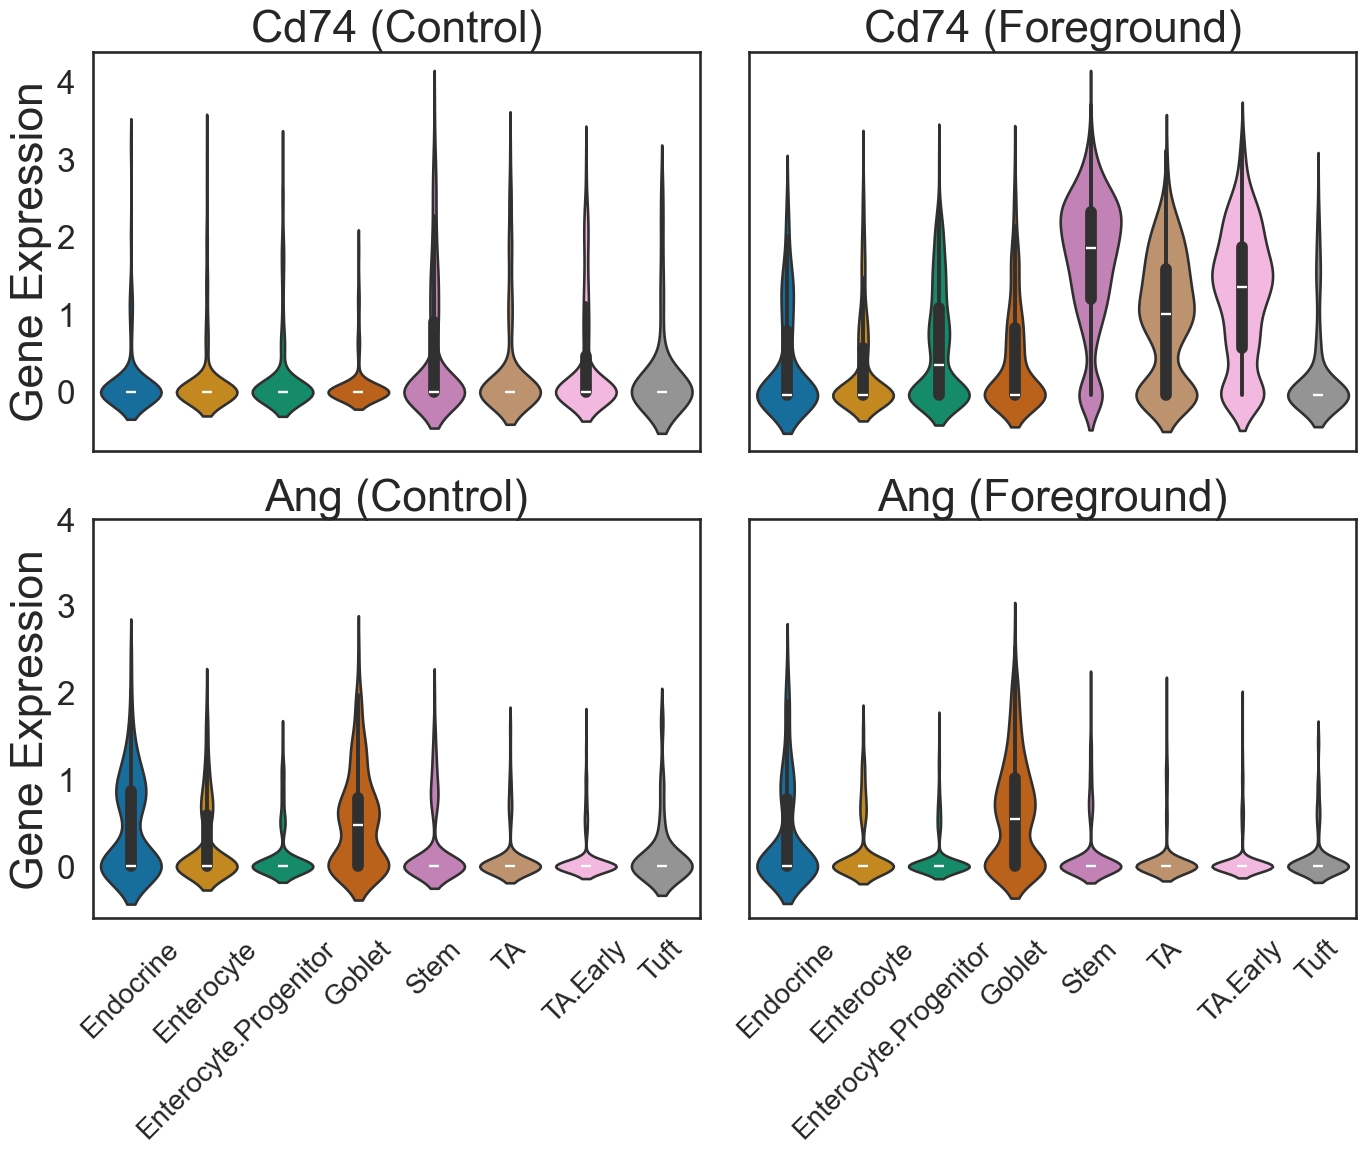

In [50]:
warnings.simplefilter(action='ignore', category=FutureWarning)

gene_names = ["Cd74", "Ang"]  
indices_to_plot = [foreground.columns.get_loc(gene) for gene in gene_names] 

foreground_cell_types = pd.Series(foreground.index.map(lambda x: x.split('_')[-1]), index=foreground.index)
background_cell_types = pd.Series(background.index.map(lambda x: x.split('_')[-1]), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

palette = sns.color_palette("colorblind", len(all_cell_types))
palette_dict = dict(zip(all_cell_types, palette))  

sns.set_theme(style="white", context="talk", palette="colorblind")
fig, axes = plt.subplots(len(indices_to_plot), 2, figsize=(14, 6 * len(indices_to_plot)), sharex='col')

for i, (gene_index, gene_name) in enumerate(zip(indices_to_plot, gene_names)):
    foreground_gene_data = foreground.iloc[:, gene_index]
    background_gene_data = background.iloc[:, gene_index]

    data_foreground = pd.DataFrame({
        'Gene Expression': foreground_gene_data.values.flatten(),
        'Cell Type': foreground_cell_types.values
    })

    data_background = pd.DataFrame({
        'Gene Expression': background_gene_data.values.flatten(),
        'Cell Type': background_cell_types.values
    })

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_background,
        order=all_cell_types, ax=axes[i, 0], palette=palette_dict
    )
    axes[i, 0].set_title(f"{gene_name} (Control)", fontsize=32)
    axes[i, 0].set_ylabel("Gene Expression", fontsize=32)
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 0].tick_params(axis='y', labelsize=24)
    axes[i, 0].set_yticks([0, 1, 2, 3, 4])  
    axes[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

    tick_labels_control = axes[i, 0].get_xticklabels()
    if len(tick_labels_control) > 2:  
        third_label_control = tick_labels_control[2]
        axes[i, 0].text(
            1.4, -3.2, third_label_control.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_control.set_visible(False)

    sns.violinplot(
        x='Cell Type', y='Gene Expression', data=data_foreground,
        order=all_cell_types, ax=axes[i, 1], palette=palette_dict
    )
    axes[i, 1].set_title(f"{gene_name} (Foreground)", fontsize=32)
    axes[i, 1].set_ylabel("")  
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[i, 1].tick_params(axis='y', left=False, labelleft=False)  
    axes[i, 1].set_yticks([0, 1, 2, 3, 4])  
    axes[i, 1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

    tick_labels_foreground = axes[i, 1].get_xticklabels()
    if len(tick_labels_foreground) > 2:  
        third_label_foreground = tick_labels_foreground[2]
        axes[i, 1].text(
            1.4, -3.2, third_label_foreground.get_text(),  
            fontsize=20, ha='center', va='bottom', rotation=45
        )
        third_label_foreground.set_visible(False)

for ax in axes[-1, :]:
    ax.set_xlabel("", fontsize=16)

plt.tight_layout()  
os.chdir('/Users/ericzhang/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/dissertation work/project 2 - contrastive cur/Pathogen')
#plt.savefig('pathogen_cfs_suppl.png', dpi=300, bbox_inches='tight')
plt.show()
